In [12]:
import numpy as np
import pandas as pd

dataset = pd.read_excel('Folds5x2_pp.xlsx')

In [13]:
dataset.shape

(9568, 5)

In [14]:
dataset.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


<Axes: >

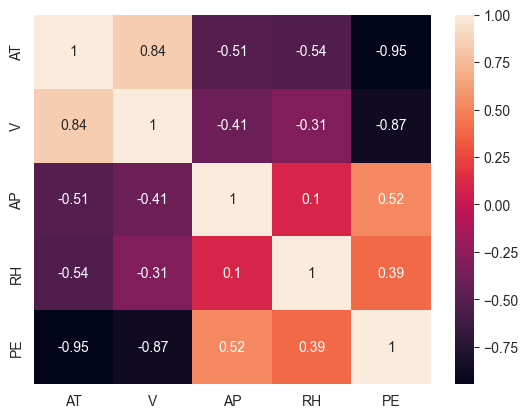

In [15]:
from seaborn import heatmap

heatmap(dataset.corr(),annot=True)

In [16]:
X = dataset.drop(columns='PE').values
y = dataset['PE'].values.reshape(-1,1)

In [17]:
from keras.models import Model
from keras.layers import Input,Dense

inputs = Input(shape=(4,), name='input', dtype=np.float32)
dense1 = Dense(16,name='dense_1', activation='relu')(inputs)
dense2 = Dense(8,name='dense_2', activation='relu')(dense1)
dense3 = Dense(32, name='dense_3',activation='relu')(dense2)
output1 = Dense(1,name='output')(dense2)


model = Model(inputs = inputs, outputs = output1, name="power_output_prediction_model")

In [18]:
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.backend import square,epsilon,sum,mean


def r_squared(y_true,y_pred):
    ss_res = sum(square(y_true - y_pred))
    ss_tot = sum(square(y_true - mean(y_true)))
    return 1 - ss_res / (ss_tot + epsilon())

model.compile(loss=MeanSquaredError(name='loss'),
              optimizer=Adam(learning_rate=0.003),
              metrics=[r_squared]
             )


In [19]:
model.summary()

Model: "power_output_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                80        
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


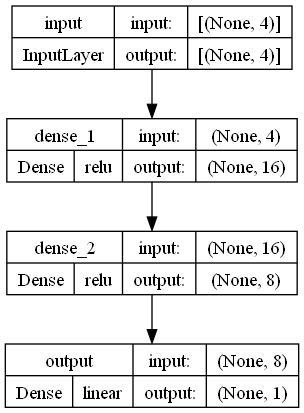

In [20]:
from keras.utils import plot_model

plot_model(model,to_file='model.png', show_shapes=True,show_layer_names=True, show_layer_activations=True)

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

weights_format = "weights/weights-{epoch:02d}.hdf5"

checkpoint = ModelCheckpoint(
    weights_format,
    monitor='loss',  # loss je parametar treniranja
    verbose=0,  # 1 da prikazuje svaki callback, ne treba
    save_best_only=True,  # svaka iteracija pamti samo najbolje tezine
    mode='min'  # ako treba da se overwrituje fajl, zapamti sa manjim lossom
)
early_stopping = EarlyStopping(monitor='loss',
                               min_delta=0.01,  # najmanja promena u odnosu na prethodnu epohu
                               patience=2,
                               # broj epoha sa promenom manjom od delta vrednosti nakon ceka trening staje
                               verbose=1,  # da prikaze zasto je trening zaustavljen
                               restore_best_weights=True)

In [22]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler



kf = KFold(n_splits=10, random_state=100, shuffle=True)
mse = []
r2 = []
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test],y[train], y[test]
    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    history = model.fit(x=X_train,y = y_train, callbacks=[early_stopping],epochs=100, batch_size=16, validation_split=0.1,shuffle=True)
    score = model.evaluate(X_test,y_test)
    mse.append(score[0])
    r2.append(score[1])

Epoch 1/100
485/485 [==============================] - 1s 1ms/step - loss: 0.0975 - r_squared: 0.8888 - val_loss: 0.0617 - val_r_squared: 0.9252
Epoch 2/100
485/485 [==============================] - 1s 1ms/step - loss: 0.0623 - r_squared: 0.9284 - val_loss: 0.0650 - val_r_squared: 0.9205
Epoch 3/100
485/485 [==============================] - 1s 1ms/step - loss: 0.0611 - r_squared: 0.9301 - val_loss: 0.0686 - val_r_squared: 0.9185
Epoch 4/100
485/485 [==============================] - 1s 1ms/step - loss: 0.0610 - r_squared: 0.9303 - val_loss: 0.0633 - val_r_squared: 0.9225
Epoch 4: early stopping
30/30 [==============================] - 0s 861us/step - loss: 0.0735 - r_squared: 0.9234
Epoch 1/100
485/485 [==============================] - 1s 1ms/step - loss: 0.0608 - r_squared: 0.9305 - val_loss: 0.0581 - val_r_squared: 0.9344
Epoch 2/100
485/485 [==============================] - 1s 1ms/step - loss: 0.0607 - r_squared: 0.9296 - val_loss: 0.0585 - val_r_squared: 0.9337
Epoch 3/100
485/

In [23]:
rmse = np.sqrt(mse)


In [24]:
pd.DataFrame(data={'Average Root Mean Squared Error': np.mean(rmse).round(3), 'STD Root Mean Squared Error': np.std(rmse).round(3), 'Average R-squared': np.mean(r2).round(3),'STD R-squared': np.std(r2).round(3)}, index=[0]).to_csv('results.csv',index=False)

In [25]:
history =  pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))

history.to_csv('history.csv', index=True, index_label = "Epoch")